### Max Fine July 2 2024

This notebook is an attempt at simulating a simple FRB burst, and injecting it into a `.fil` file using the `will` github stuff

i am mostly following their example notebook

In [77]:
# imports

In [60]:
from your import Writer, Your

In [112]:
import tempfile
from urllib import request
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion import dedisperse
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject
from your import Your

import matplotlib.pyplot as plt
from your.formats.pysigproc import SigprocFile
import numpy as np
from your import Writer, Your
from ipywidgets import interact
import os


# data dir
datadir = '/data/frb/2024-06-25/'

# file
pv_file = 'FRB20240209A_PV_Band_2024_06_25_15_27_36.fil'
ph_file = 'FRB20240209A_PH_Band_2024_06_25_15_30_27.fil'
l1_file = 'FRB20240209A_L1_Band_2024_06_25_15_30_27.fil'
l2_file = 'FRB20240209A_L2_Band_2024_06_25_15_30_27.fil'

data_files = [pv_file, ph_file, l1_file, l2_file]

In [113]:
def show_dynamic(
    dynamic_spectra: np.ndarray,
    title: Union[str, None] = None,
    save: Union[bool, None] = False,
) -> None:
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra - the dynamic spectra to plot

        title - Title of plot

        save - Save the plot as `title` + `.png`
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    print('shape of flat', np.shape(flat))
    
    #flat[flat > 1e3] = 0 # this hould make a mask?
    print('shape of flat', np.shape(flat))
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(20, 10))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std, aspect="auto")
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title.replace(" ", "_") + ".png", dpi=75, bbox_inches="tight")

shape of flat (8192, 4096)
shape of flat (8192, 4096)


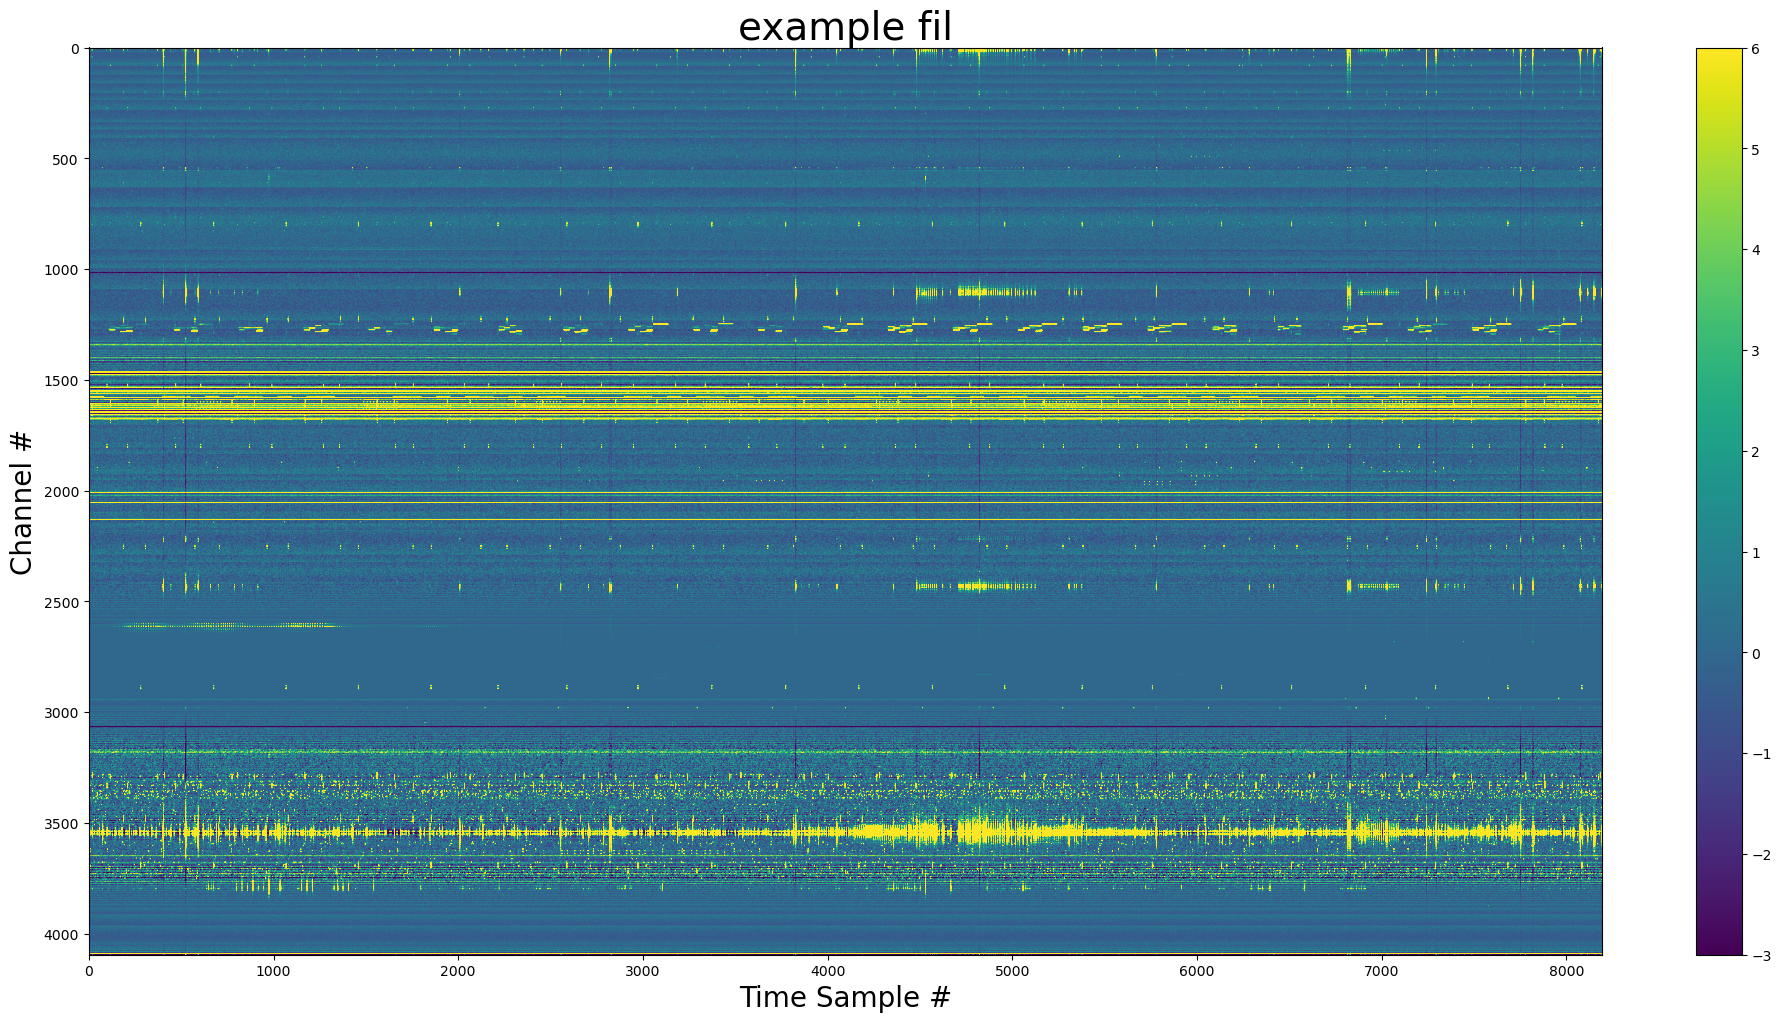

In [120]:
# Get a 33MB filbterbank from zenodo, put it in
# a temp directory
temp_dir = tempfile.TemporaryDirectory()
empty_fil = temp_dir.name + "/empty_example.fil"
request.urlretrieve(
    "https://zenodo.org/record/5860557/files/empty_example.fil", empty_fil
)

yr_obj = Your(empty_fil)
dynamic_spectra = yr_obj.get_data(0, 8192)
# Show the base dynamic spectra
show_dynamic(dynamic_spectra, title='example fil')

shape of flat (8192, 160)
shape of flat (8192, 160)


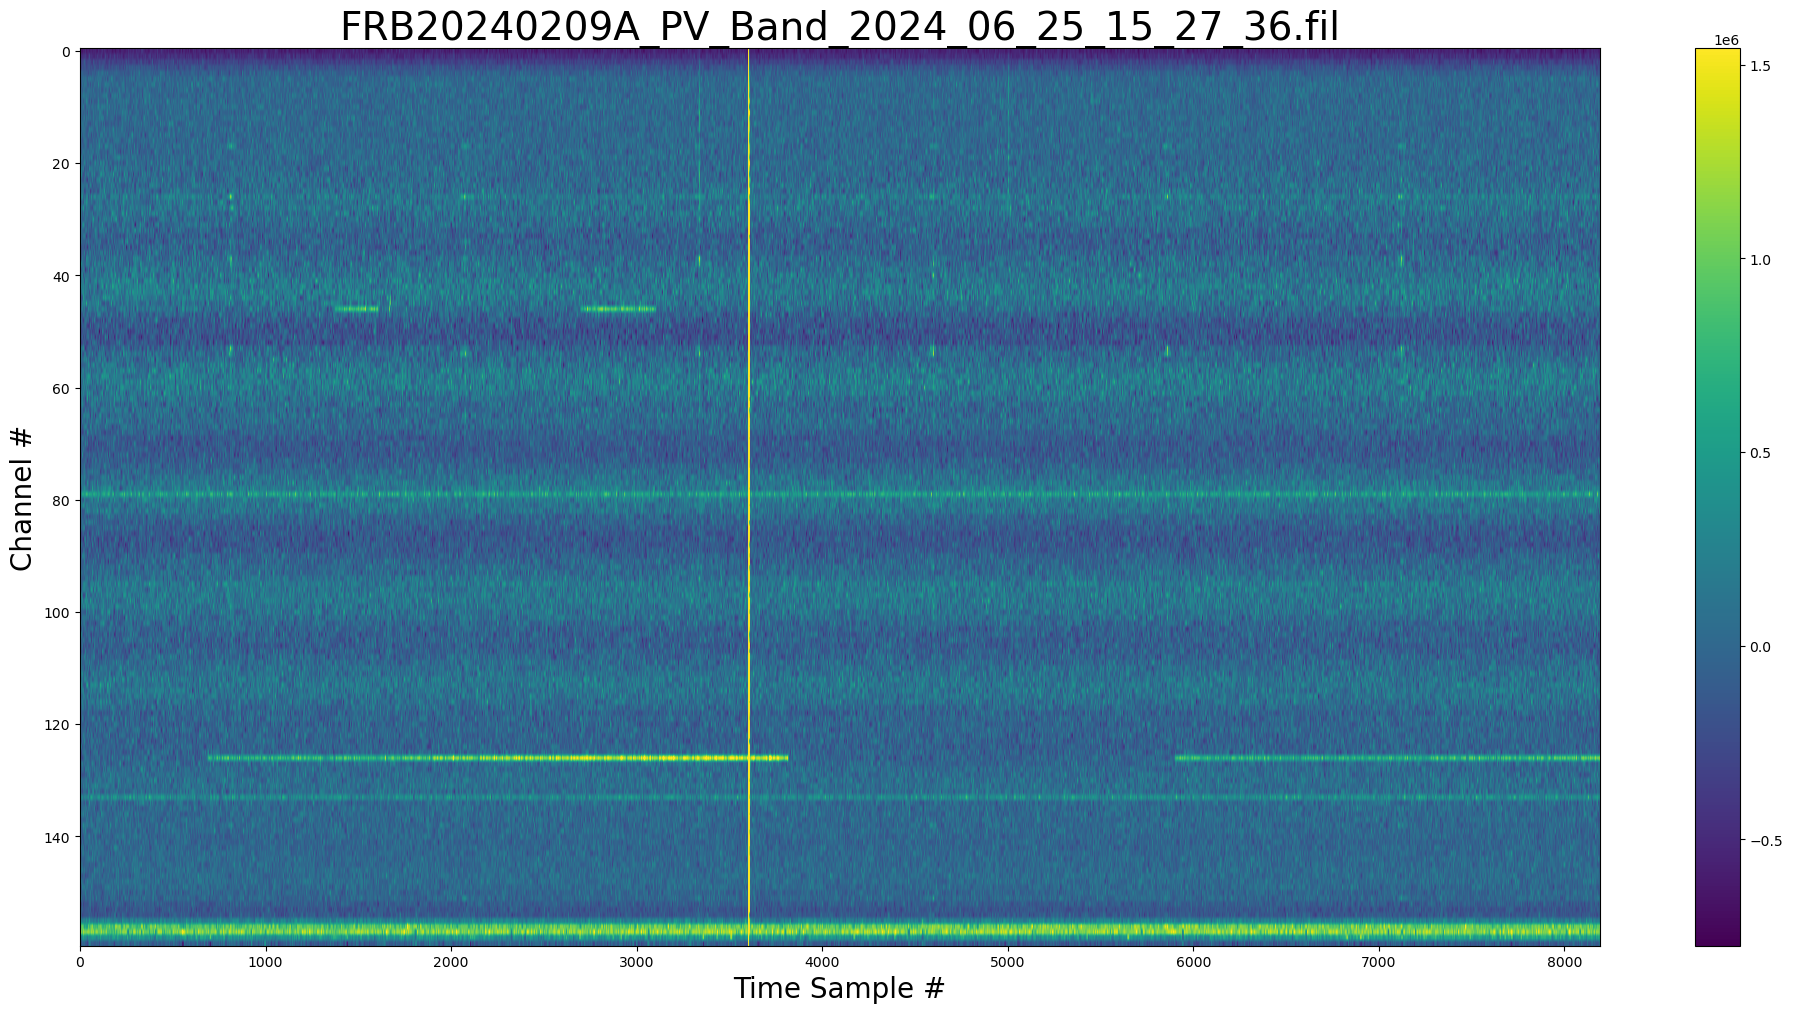

In [121]:

empty_fil = datadir + data_files[1]
yr_obj = Your(empty_fil)
dynamic_spectra = yr_obj.get_data(0, 8192)
# Show the base dynamic spectra
show_dynamic(dynamic_spectra, title=data_files[0])

## Find a bandpass to scale the frequency structure

shape of medians (160,)


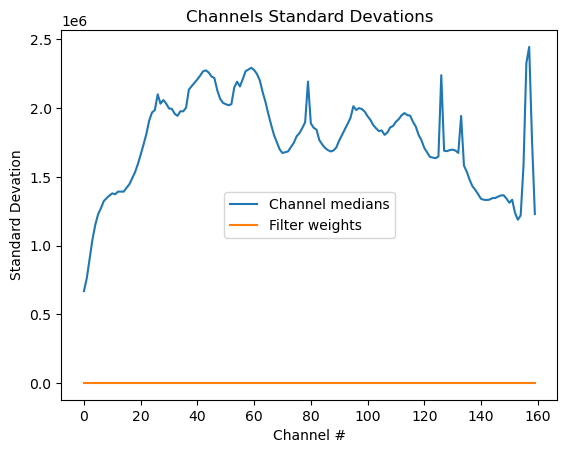

In [122]:
plt.title("Channels Standard Devations")
plt.xlabel("Channel #")
plt.ylabel("Standard Devation")
medians = np.median(dynamic_spectra, axis=0)
print('shape of medians', np.shape(medians))
plt.plot(medians, label="Channel medians")
filter_weights = create.filter_weights(dynamic_spectra)
# mutlipy by 10 to make it easier to see
plt.plot(10 * filter_weights, label="Filter weights")
plt.legend()

In [123]:
filter_weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

## Create the pulse

In [99]:
yr_obj.your_header.center_freq

410.0625

In [124]:
dm = 200
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    #relative_intensities = 1000,
    sigma_time=0.001,
    sigma_freq=3,
    center_freq=yr_obj.your_header.center_freq,
    dm=dm,
    tau=20,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=filter_weights,
)
# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5))

In [125]:
#help(create.GaussPulse)

In [126]:
'''m = 200
# create the pulse object
pulse_obj = create.GaussPulse(
    relative_intensities = np.asarray([1000.0]),
    sigma_times=np.asarray([0.001]),
    sigma_freqs=np.asarray([3]),
    center_freqs=np.asarray([yr_obj.your_header.center_freq]),
    dm=dm,
    pulse_thetas = np.pi/3,
    offsets = 1500,
    tau=20,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=filter_weights,
)
# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e3))'''

'm = 200\n# create the pulse object\npulse_obj = create.GaussPulse(\n    relative_intensities = np.asarray([1000.0]),\n    sigma_times=np.asarray([0.001]),\n    sigma_freqs=np.asarray([3]),\n    center_freqs=np.asarray([yr_obj.your_header.center_freq]),\n    dm=dm,\n    pulse_thetas = np.pi/3,\n    offsets = 1500,\n    tau=20,\n    phi=np.pi / 3,\n    spectral_index_alpha=0,\n    chan_freqs=yr_obj.chan_freqs,\n    tsamp=yr_obj.your_header.tsamp,\n    nscint=0,\n    bandpass=filter_weights,\n)\n# pulse with 3e5 samples\npulse = pulse_obj.sample_pulse(nsamp=int(3e3))'

shape of flat (2694, 160)
shape of flat (2694, 160)


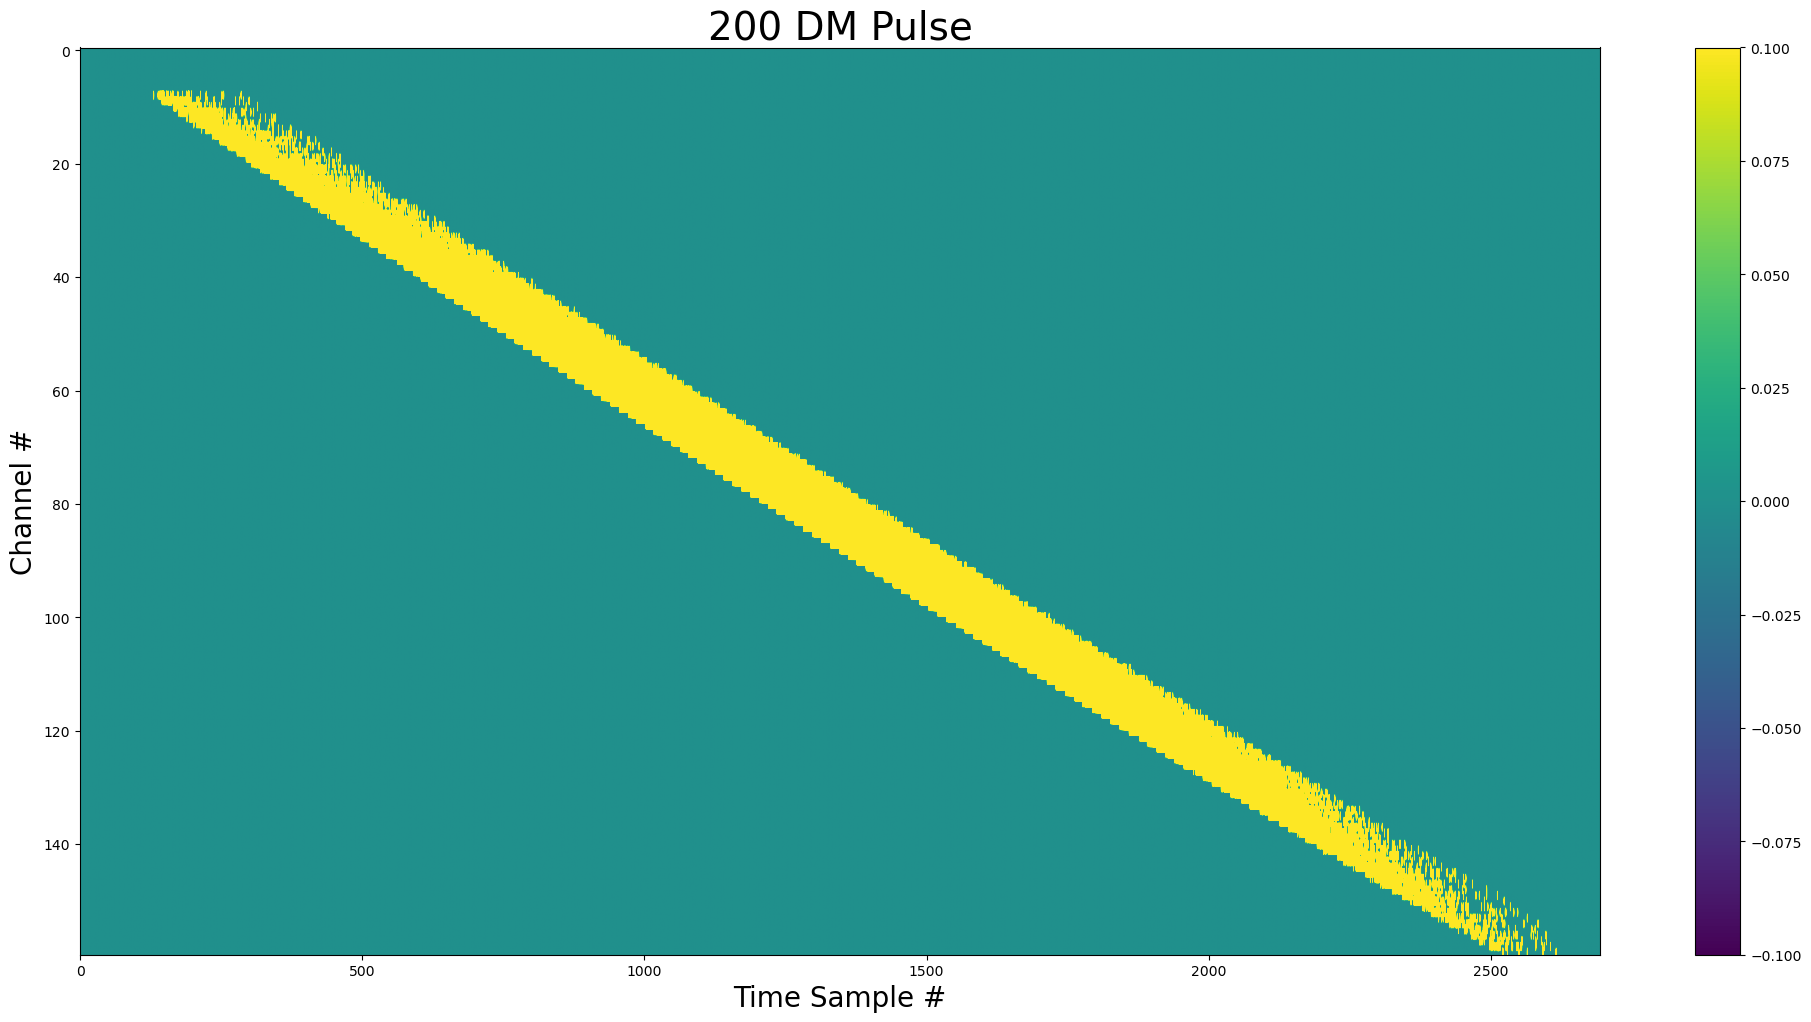

In [127]:
show_dynamic(pulse, title=f"{dm} DM Pulse")

## Inject the pulse

In [128]:
# Convert dtype to unsigned integer type if needed
yr_obj.your_header.dtype = np.uint64  # Example of converting to uint64; adjust as necessary


dynamic_spectra_w_pulse = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse,
    start=5000,
    gulp=yr_obj.your_header.nspectra,
)



Output()

In [129]:
np.shape(dynamic_spectra_w_pulse)

(3125000, 160)

shape of flat (8192, 160)
shape of flat (8192, 160)


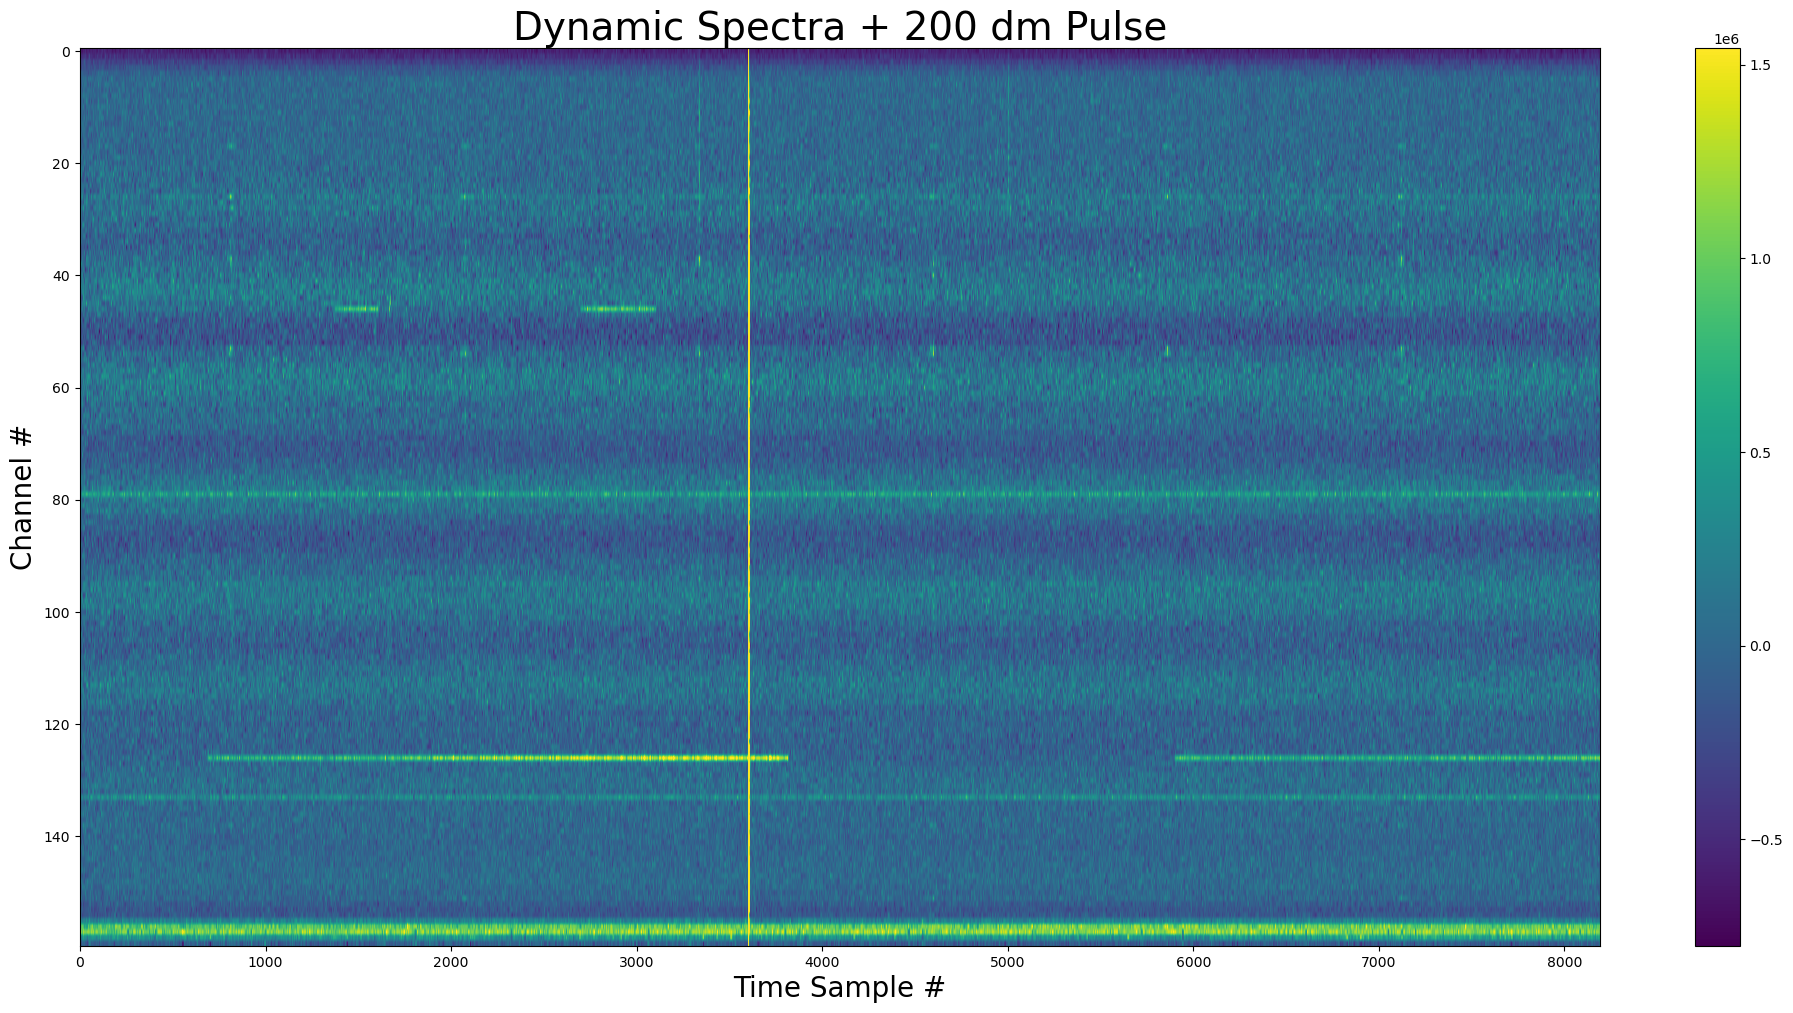

In [130]:
show_dynamic(dynamic_spectra_w_pulse[0:8192,:], title=f"Dynamic Spectra + {dm} dm Pulse")

In [53]:
start=yr_obj.your_header.nspectra // 2 - 160

In [55]:
start /1e6

1.56234

## Variable Fluence

In [36]:
# Calculate the number of pulses needed
n_pulses = inject.num_pulses(period=1234, nspectra=yr_obj.your_header.nspectra)
print(f"Number of pulses: {n_pulses}")

Number of pulses: 2533


In [37]:
np.random.seed(2021)
pulse_energies = np.random.normal(loc=3e5, scale=2e5, size=n_pulses)
# pulse engergies must be an interger number of samples
np.around(pulse_energies, out=pulse_energies)
# must be positive
pulse_energies = pulse_energies.astype(int)
np.clip(pulse_energies, 0, None, out=pulse_energies)
print(f"{pulse_energies=}")

pulse_energies=array([597722, 435202, 216310, ..., 378506, 159576, 665803])


In [38]:
dynamic_spectra_w_pulse_perodic_diff_energies = inject.inject_distribution_into_file(
    yr_input=yr_obj,
    pulse_obj=pulse_obj,
    pulse_counts=pulse_energies,
    start=0,
    period=1234,
    gulp=yr_obj.your_header.nspectra,
)

Output()

shape of flat (16384, 160)
shape of flat (16384, 160)


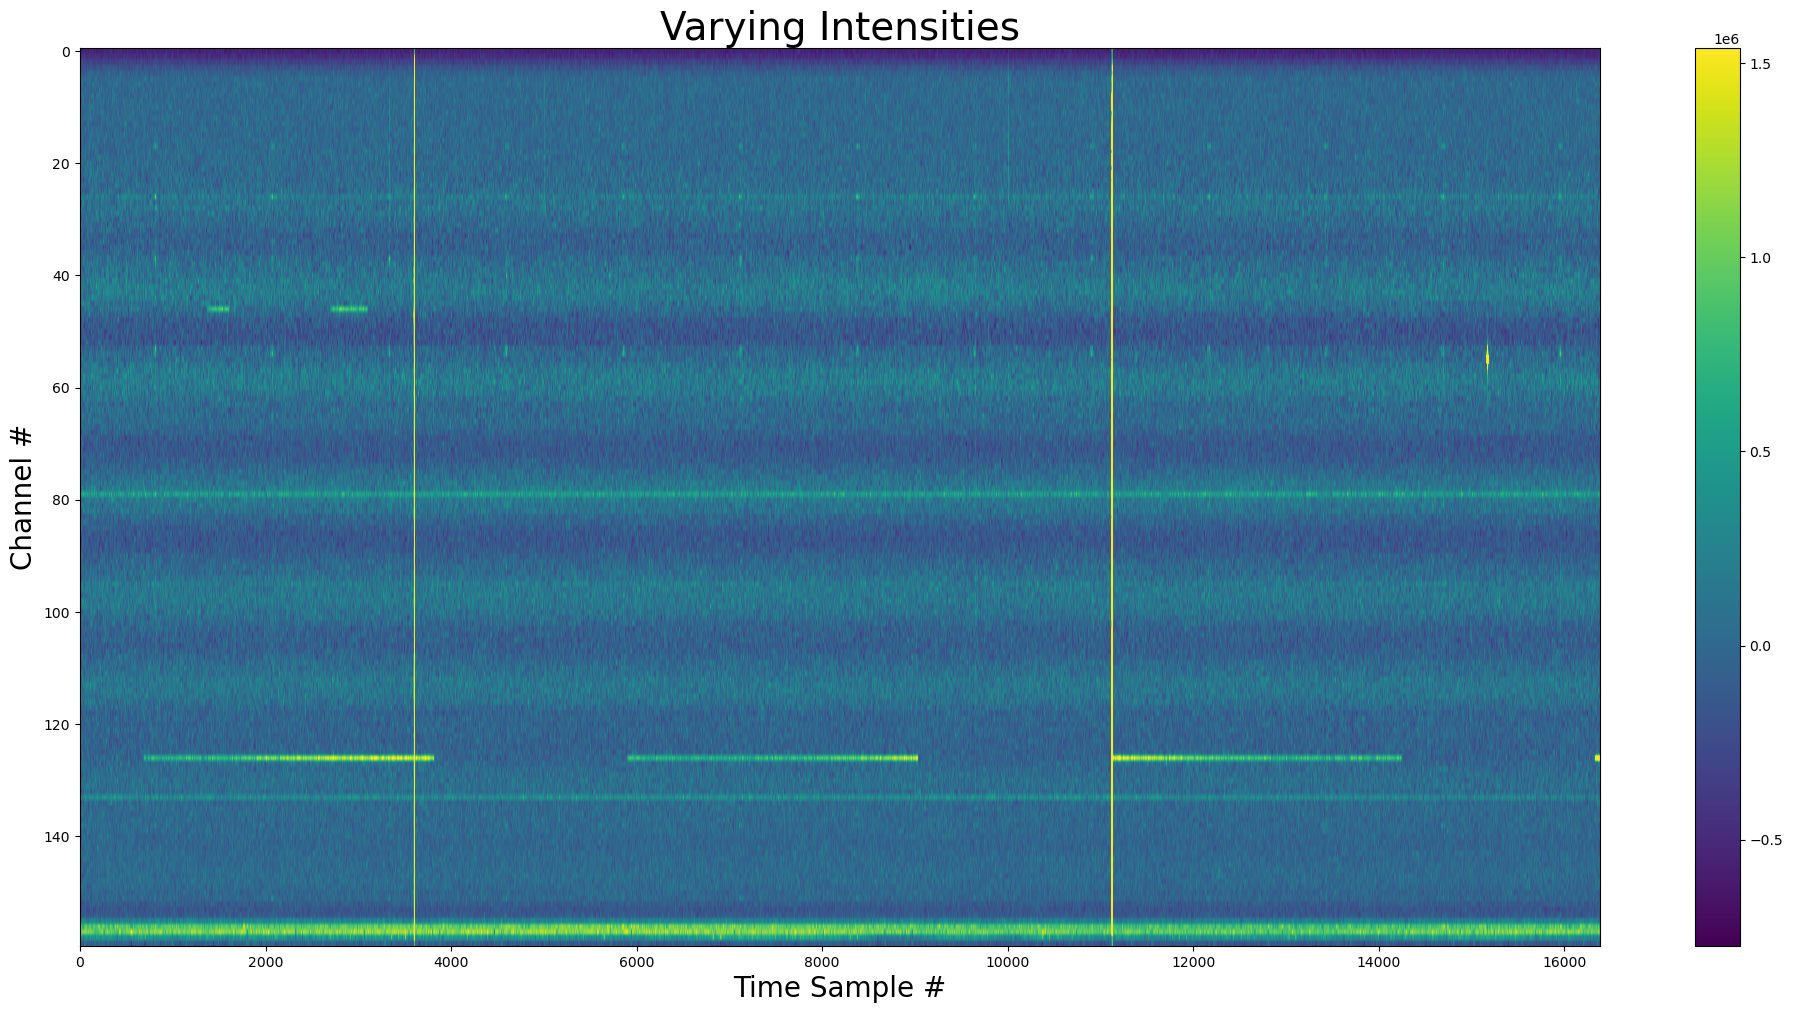

In [39]:
show_dynamic(
    dynamic_spectra_w_pulse_perodic_diff_energies[0:2*8192,:],
    title="Varying Intensities",
    save=True,
)

### Trying to write out / save a `.fil` file

In [65]:
yr_obj.your_header.nspectra // 2 - 160

1562340

In [47]:
pwd

'/home_local/maxfine/injection_simulations'

In [50]:
fil = SigprocFile('/data/frb/2024-06-25/FRB20240209A_PH_Band_2024_06_25_15_30_27.fil')

In [58]:
import numpy as np
from your.writer import Writer

# Step 1: Create a synthetic data array as an example
data = dynamic_spectra_w_pulse_perodic_diff_energies

# Step 2: Define the necessary parameters for the Writer
your_object = yr_obj # Replace with your actual object if needed
nstart = 0
outdir = '/home_local/maxfine/injection_simulations'
outname = 'FRB20240209A_PH_Band_2024_06_25_15_30_27_test_sim.fil'

# Step 3: Create an instance of the Writer class
sigproc_file = fil
# Step 2: Retrieve header attributes
header = {
    'telescope_id': sigproc_file.machine_id,
    'machine_id': sigproc_file.machine_id,
    'data_type': 1,  # Assuming data_type is 1 (filterbank data)
    'source_name': sigproc_file.source_name,
    'barycentric': sigproc_file.barycentric,
    'pulsarcentric': sigproc_file.pulsarcentric,
    'az_start': sigproc_file.az_start,
    'za_start': sigproc_file.za_start,
    'src_raj': sigproc_file.src_raj,
  # 'src_dej': sigproc_file.src_deg,
    'tstart': sigproc_file.tstart,
    'tsamp': sigproc_file.tsamp,
    'nifs': sigproc_file.nifs,
    'fch1': sigproc_file.fch1,
    'foff': sigproc_file.foff,
    'nchans': sigproc_file.nchans,
    'nbeams': sigproc_file.nbeams,
    'ibeam': sigproc_file.ibeam,
    'nbits': sigproc_file.nbits,
    'rawdatafile': 'new_simulation.fil'  # Name of the new file
}

writer = Writer(
    your_object=sigproc_file,
    nstart=fil.fch1,
   # nsamp=fil.nsamp,
  #  nstart=0,
    c_min=0,
    c_max=nchans,
    npoln=1,
    highest_frequency_first=False, #idk if i is like this or not
    outdir=outdir,
    outname=outname,
    flag_rfi=False,
    progress=True
)

# Step 4: Write the data to a .fil file
writer.to_fil(data=data)


AttributeError: 'SigprocFile' object has no attribute 'your_header'

In [48]:
yr_obj

Using <class 'str'>:
/data/frb/2024-06-25/FRB20240209A_PH_Band_2024_06_25_15_30_27.fil

In [81]:
# Step 4: Write the data to a .fil file
yr_obj.outdir = '/home_local/maxfine/injection_simulations'
yr_obj.outname = 'FRB20240209A_PH_Band_2024_06_25_15_30_27_test_sim.fil'
yr_obj.npoln =1
sigproc_file.your_object = yr_obj
sigproc_file.progress = True
sigproc_file.nsamp = sigproc_file.tsamp
Writer.to_fil(yr_obj, data=data, )

Output()

AttributeError: 'Your' object has no attribute 'progress'

In [64]:
pwd

'/home_local/maxfine/injection_simulations'

In [69]:
sigproc_file

In [70]:
yr_obj


Using <class 'str'>:
/data/frb/2024-06-25/FRB20240209A_PH_Band_2024_06_25_15_30_27.fil

In [107]:
your_original_file = Your("/data/frb/2024-06-25/FRB20240209A_PH_Band_2024_06_25_15_30_27.fil")

In [90]:
your_original_file.your_header

Unified Header:
  "basename": "FRB20240209A_PH_Band_2024_06_25_15_30_27"
  "bw": -20.0
  "center_freq": 410.0625
  "dec_deg": 86.05994641005378
  "dtype": "float32"
  "fch1": 420.0
  "filelist": [
    "/data/frb/2024-06-25/FRB20240209A_PH_Band_2024_06_25_15_30_27.fil"
  ]
  "filename": "/data/frb/2024-06-25/FRB20240209A_PH_Band_2024_06_25_15_30_27.fil"
  "foff": -0.125
  "format": "fil"
  "frequency_decimation_factor": 1
  "gb": 26.57698185257742
  "gl": -61.44113312561997
  "native_foff": -0.125
  "native_nbits": 32
  "native_nchans": 160
  "native_nspectra": 3125000.0
  "native_tsamp": 0.000192
  "nbits": 32
  "nchans": 160
  "npol": 1
  "nspectra": 3125000
  "poln_order": "I"
  "ra_deg": 289.91000211383255
  "source_name": "FRB20240209A"
  "time_decimation_factor": 1
  "tsamp": 0.000192
  "tstart": 60486.562939814816
  "tstart_utc": "2024-06-25T13:30:38.000"

In [111]:
Writer(your_object=yr_obj, outname="FRB60", outdir='/home_local/maxfine/injection_simulations').to_fil(data=dynamic_spectra_w_pulse_perodic_diff_energies)

Output()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [99]:
ls

 example_inject_pulse.ipynb
 extract_reinject_pulse.ipynb
'FRB20240209A_L1_Band_2024_06_25_15_30_27.fil'$'\n'' Dynamic Spectrum.png'
'FRB20240209A_L2_Band_2024_06_25_15_30_27.fil'$'\n'' Dynamic Spectrum.png'
'FRB20240209A_PH_Band_2024_06_25_15_30_27.fil'$'\n'' Dynamic Spectrum.png'
'FRB20240209A_PV_Band_2024_06_25_15_27_36.fil'$'\n'' Dynamic Spectrum.png'
 hello_world.ipynb
 inject_pulse.ipynb
 inspecting_fil_file.ipynb
 l1_band_master.ignorechans
 l2_band_master.ignorechans
 Multi-Component_Pulse.png
 p_band_master.ignorechans
 Pulsar_with_Varying_Intensities.png
 test.html
 test_injection.ipynb
 Untitled1.ipynb
 Untitled.ipynb
 Varying_Intensities.png


In [104]:
help(your.writer)

Help on module your.writer in your:

NAME
    your.writer

CLASSES
    builtins.object
        Writer
    
    class Writer(builtins.object)
     |  Writer(your_object, nstart=0, nsamp=None, c_min=None, c_max=None, npoln=1, highest_frequency_first=False, outdir=None, outname=None, flag_rfi=False, progress=True, spectral_kurtosis_sigma=4, savgol_frequency_window=15, savgol_sigma=4, gulp=None, zero_dm_subt=False, time_decimation_factor=1, frequency_decimation_factor=1, replacement_policy='mean')
     |  
     |  The unified writer class.
     |  
     |  Args:
     |  
     |      your_object: Your object
     |      nstart (int): Start sample to read from
     |      nsamp (int): Number of samples to write
     |      c_min (int): Starting channel index (default: 0)
     |      c_max (int): End channel index (default: total number of frequencies)
     |      npoln (int): Number of output polarisations (default: 1)
     |      highest_frequency_first (bool): The output should have highes

In [102]:
import your